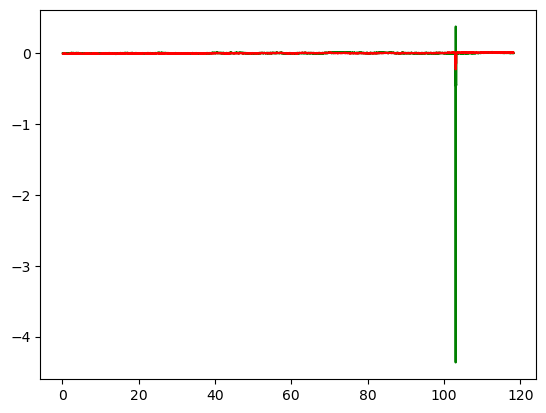

In [253]:
#CELL 1

#Establish Mouse Signal and Time Dictionary
#Establish DFF across all time

import numpy as np
import scipy.ndimage as nd
from scipy.io import loadmat
from numpy.linalg import norm
import matplotlib.pyplot as plt
import pickle as p
#import functions.data_io as dataio
#import functions.plot as plot
import os
import re
import h5py

directory = '/Users/rishachakraborty/Downloads'

datanames = ['_FPConsole_Signals_Series0001_AIN01xAOUT01-LockIn','_FPConsole_Signals_Series0001_AIN01xAOUT02-LockIn','_FPConsole_Signals_Series0001_AIN02xAOUT03-LockIn','_FPConsole_Signals_Series0001_DigitalIO']

datanames_new = ['405','470','568','TTL1','TTL2']

dataprobe = load_doric('/Users/rishachakraborty/Downloads/Console_Acq_0001.doric', 6, datanames, datanames_new)

dff470 = (np.array(dataprobe['470']) - np.polyval(linreg(np.array(dataprobe['405']),np.array(dataprobe['470'])), np.array(dataprobe['405'])))/np.polyval(linreg(np.array(dataprobe['405']),np.array(dataprobe['470'])), np.array(dataprobe['405']))
dff568 = (np.array(dataprobe['568']) - np.polyval(linreg(np.array(dataprobe['405']),np.array(dataprobe['568'])), np.array(dataprobe['405'])))/np.polyval(linreg(np.array(dataprobe['405']),np.array(dataprobe['568'])), np.array(dataprobe['405']))

plt.plot(dataprobe['time'], dff470, color = "green")
plt.plot(dataprobe['time'], dff568, color = "red")


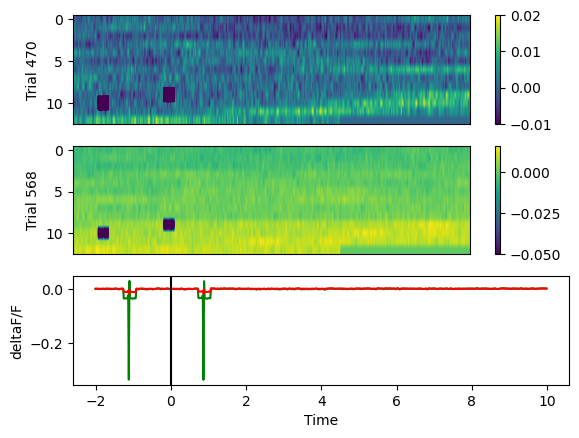

In [263]:
cuetimes = getcuetimes(np.array(dataprobe['time']), np.array(dataprobe['TTL2']))

for i in range(len(cuetimes)):
    left = np.where(dataprobe['time'] == cuetimes[i])[0][0]-120
    right = np.where(dataprobe['time'] == cuetimes[i])[0][0]+600
    dff470array = np.zeros(720)
    dff568array = np.zeros(720)
    dff470array[0:len(dff470[left:right])] = dff470[left:right]
    dff568array[0:len(dff568[left:right])] = dff568[left:right]
    if i == 0:
        dff470acrosstrials = dff470array
        dff568acrosstrials = dff568array
    else:
        dff470acrosstrials = np.vstack((dff470acrosstrials,dff470array))
        dff568acrosstrials = np.vstack((dff568acrosstrials,dff568array))


averagedff470 = np.mean(dff470acrosstrials,axis=0)
averagedff568 = np.mean(dff568acrosstrials,axis=0)

fig,axs = plt.subplots(3, 1)

im1 = axs[0].imshow(dff470acrosstrials,vmin = -0.01, vmax = 0.02, aspect='auto')
axs[0].set(ylabel='Trial 470', xticks = [])
fig.colorbar(im1)

im2 = axs[1].imshow(dff568acrosstrials,vmin = -0.05, aspect='auto')
axs[1].set(ylabel='Trial 568', xticks = [])
fig.colorbar(im2)


axs[2].plot(np.arange(-2,10,(1/60)),averagedff470,color = "green")
axs[2].plot(np.arange(-2,10,(1/60)),averagedff568,color = "red")
axs[2].set(xlabel = 'Time',ylabel = 'deltaF/F')
plt.axvline(0, color='black')



In [86]:
def getcuetimes(time,signal):
    timearray = [time[np.where(signal==1)][0]]
    for i in range(len(time[np.where(signal==1)])):
        if time[np.where(signal==1)][i] > (timearray[-1] + 1):
            timearray = np.append(timearray,time[np.where(signal==1)][i])
    return timearray

def linreg(array1,array2):
    m = (len(array1) * np.sum(array1*array2) - np.sum(array1) * np.sum(array2)) / (len(array1)*np.sum(array1*array1) - np.sum(array1) ** 2)
    b = (np.sum(array2) - m *np.sum(array1)) / len(array1)
    return [m,b]

def ish5dataset(item):
    """Check if the given item is in HDF5 format. Function from doric.

    Args:
        item: any variable you want to know if it's format is HDF5

    Returns:
        boolean: 1 if item is HDF5, 0 if not.
    """
    return isinstance(item, h5py.Dataset)


def h5getDatasetR(item, leading=''):
    """Read data from HDF5 file. Function from doric.

     Args:
          item (h5fp file object w/ r mode): This can work as like a Python dictionary - you can access to its data using key.
          leading (str): leading string that you want to put before your key in the name (e.g., filepath)

    Returns:
        boolean: 1 if item is HDF5, 0 if not.

    """

    r = []
    for key in item:
        # First have to check if the next layer is a dataset or not
        firstkey = list(item[key].keys())[0]
        if ish5dataset(item[key][firstkey]):
            r = r + [{'Name': leading + '_' + key, 'Data':
                [{'Name': k, 'Data': np.array(item[key][k]),
                  'DataInfo': {atrib: item[key][k].attrs[atrib] for atrib in item[key][k].attrs}} for k in
                 item[key]]}]
        else:
            r = r + h5getDatasetR(item[key], leading + '_' + key)

    return r

def ExtractDataAcquisition(filename, version):
    """Main function that reads data from '.doric' file. Modified function provided by doric.

    Args:
        filename (str): Full file path of '.doric' file
        version (int): 5 or 6. Version number of Doric Neuroscience Studio. Key is different depending on version.

    Returns:
        The acquired data of '.doric' file, which includes time stamps, fluorescence signals (from 405 and 470nm), and
        TTL signals (from TTL 1 and TTL 2).
    """

    with h5py.File(filename, 'r') as h:
        if version == 5:
            return h5getDatasetR(h['Traces'])
        elif version == 6:
            return h5getDatasetR(h['DataAcquisition'])


def load_doric(filename, version, datanames, datanames_new):
    """Function to read doric data file (.doric) and save it in a general format.

    Args:
        filename (str): Full file path of '.doric' file
        version (int): 5 or 6. Version number of Doric Neuroscience Studio. Key is different depending on version.
        datanames (str list): Default data names in raw '.doric' file
        datanames_new (str list): The new data names. This should be the same across different photometry systems
            (doric and pyphotometry), so that we can easily access to the data using the same fundtion regardless of the
            data acquisition system.

    Returns:
        data (dict): Dictionary that stores all acquired data from doric. Keys are the datanames_new.
    """
    # TODO(HuijeongJeong): develop for version 6

    # Read doric data as a list of dictionary. Each dictionary contains default data name ('Name') in raw '.doric' file,
    # and corresponding data ('Data'). datanames should be a subset of Name of dictionaries.
    

    # save data in a pretty form with datanames_new
    data = {}
    
    if version == 5:
        doricfile = [data["Data"][0] for data in ExtractDataAcquisition(filename, 5)]
        
        # save time
        data['time'] = [data["Data"] for data in doricfile if data["Name"] == 'Console_time(s)'][0].tolist()
        
       # save other data
        for i, v in enumerate(datanames):
            data[datanames_new[i]] = [data["Data"] for data in doricfile if data["Name"] == v][0].tolist()
            
    elif version == 6:
        extractedData = ExtractDataAcquisition(filename, 6)
        dio = {}
        
        # save time
        data['time'] = [data["Data"] for data in [doricdata["Data"][0] for doricdata in extractedData] if data["Name"] == 'Time'][0].tolist()
     
       #save other data
        for i, v in enumerate(datanames):
            
            #save signal data
            if v != '_FPConsole_Signals_Series0001_DigitalIO':
                data[datanames_new[i]] = [ddata["Data"] for ddata in [doricdata["Data"][1] for doricdata in extractedData if doricdata["Name"] == v] if ddata["Name"] == "Values"][0].tolist()
           
            #save digital data and interpolate with time in case digital time and signal time don't match
            else:
                dio[0] = [ddata["Data"] for ddata in [doricdata["Data"][0] for doricdata in extractedData if doricdata["Name"] == v] if ddata["Name"] == "DIO01"][0].tolist()
                dio[1] = [ddata["Data"] for ddata in [doricdata["Data"][1] for doricdata in extractedData if doricdata["Name"] == v] if ddata["Name"] == "DIO02"][0].tolist()
                dio[2] = [ddata["Data"] for ddata in [doricdata["Data"][2] for doricdata in extractedData if doricdata["Name"] == v] if ddata["Name"] == "Time"][0].tolist()
                data[datanames_new[i]] = np.floor(np.interp(np.array(data['time']),np.array(dio[2]),np.array(dio[0])))
                data[datanames_new[i+1]] = np.floor(np.interp(np.array(data['time']),np.array(dio[2]),np.array(dio[1])))
    return data




In [216]:
dataprobe['time'][2]-dataprobe['time'][1]

0.01659999999999999